# Recommender ChatBot: Build items and interactions data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

BASE_PATH    = '../..'
LIB_PATH     = f'{BASE_PATH}/lib'
API_PATH     = f'{BASE_PATH}/chat-bot-api'
DATASET_PATH = f'{BASE_PATH}/datasets'
ITEMS_PATH   = f'{DATASET_PATH}/chatbot-api-movies.json'


os.environ['TMP_PATH']               = f'{BASE_PATH}/tmp'
os.environ['DATASET_PATH']           = f'{BASE_PATH}/datasets'
os.environ['WEIGHTS_PATH']           = f'{BASE_PATH}/weights'
os.environ['METRICS_PATH']           = f'{BASE_PATH}/metrics'
os.environ['MONGODB_URL']            = 'mongodb://0.0.0.0:27017'
os.environ['MONGODB_DATABASE']       = 'chatbot'
os.environ['CHROMA_HOST']            = '0.0.0.0'
os.environ['CHROMA_PORT']            = '9090'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [3]:
import sys
sys.path.append(LIB_PATH)
sys.path.append(API_PATH)

import pandas as pd

import util as ut

import torch
import data as dt
import data.dataset as ds

import os

from client import RecChatBotV1ApiClient

from services import ItemSimQuery

from app_context import AppContext

import pytorch_common.util as pu
from datetime import datetime

from rest import TMDBApiClient

import logging
from dataclasses import dataclass
from abc import ABC, abstractmethod
from IPython.core.display import HTML

<Figure size 640x480 with 0 Axes>

# Setup

In [4]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

# Common Functions and Classes

In [5]:
def cos_sim(a, b, k=1):
    from strsimpy import Cosine
    sim = Cosine(k=k)
    return 1 - sim.distance(a, b)

In [6]:
def is_empty(value):
    if value is None: return True
    
    if type(value) == str and len(value) == 0: return True

    if type(value) == list:
        if len(value) == 0: return True
        if len([True for v in value if is_empty(v)]) == len(value): return True

    return False

In [7]:
def items_to_df(models):
    return pd.DataFrame([
        {
            'id'          : model.id,
            'title'       : model.title,
            'release'     : model.release,
            'genres'      : model.genres,
            'rating'      : model.rating,
            'poster'      : model.poster
        }
        for model in models
    ])


def ints_to_df(models):
    return pd.DataFrame([
        {
            'item_id' : model.user_id,
            'user_id' : model.item_id,
            'rating'  : model.rating
        }
        for model in models
    ])

In [8]:
async def append_popularity_score(items, interactions):
    from sklearn.preprocessing import MinMaxScaler

    item_votes = interactions \
        .groupby(['item_id'])['user_id'] \
        .size() \
        .reset_index(name='votes') \
        .rename(columns={'item_id': 'id'})

    
    item_votes['id'] = item_votes['id'].astype(str)

    items = item_votes.merge(items, on='id')
    
    items['votes_norm']       = items['votes'] / items['votes'].max()
    items['popularity_score'] = items['rating'] * items['votes_norm']
    items = items.drop(['votes_norm'], axis=1)

    return items.sort_values(
        by        = ['popularity_score'],
        ascending = False
    )

In [9]:
def to_image_html(path, width=300, alt='Not Found Image'): return F'<img src="{path}" width="{width}" alt={alt} >'

def show(df): display(HTML(df.to_html(escape=False)))

In [10]:
async def search_items_by_content(
    interactions,
    content,
    min_release      = None,
    min_rating       = None,
    order_popularity = True,
    limit            = 10_000
):
    items, _ = await ctx.item_service.find_similars_by(
        ItemSimQuery() \
            .contains(content) \
            .rating_gte(min_rating) \
            .release_gte(min_release) \
            .limit_eq(limit)
    )
    
    items = items_to_df(items)
                
    if order_popularity:
        items = await append_popularity_score(items, interactions)

    items['poster'] = items['poster'].apply(to_image_html)
    
    return items.reset_index()

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_max_user_interactions_bins(df, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    sns.barplot(x='n_interactions_bin', y='n_users', data=df)
    plt.title('Max user interactions by range')
    plt.xlabel('Max user interactions')
    plt.ylabel('Users count')
    plt.xticks(rotation=45)
    plt.show()

In [12]:
@dataclass(frozen=True)
class MovieDataSeeker:
    data                   : pd.DataFrame
    min_title_sim          : int          = 0.98
    min_original_title_sim : int          = 0.98

    
    def search_many_by(self, title_by_id, fields=[]):
        movies = {}
        with dt.progress_bar(len(title_by_id), title='Fetching many movies from TMDB') as pb:
                
            for id, title in title_by_id.items():
                movie = self.search_by(id, title, fields)
                if movie:
                    movies[id] = movie
                pb.update()

        return movies


    def search_by(self, id, title, fields=[]):
        movie_data = {}
        movies = self.data[id]
        if len(movies) > 0:
            for movie in movies:
                title_sim          = cos_sim(title, movie['title'])
                original_title_sim = cos_sim(title, movie['original_title'])

                title_eq = movie['title'].strip().lower() == title.strip().lower() or movie['original_title'].strip().lower() == title.strip().lower()
                
                title_match = title_sim > self.min_title_sim or original_title_sim > self.min_title_sim

                if title_eq or title_match:
                    logging.debug(f'title sim: {title_sim}, original title sim: {original_title_sim}')

                    for field in fields:
                        value = movie[field]
                        if not is_empty(value):
                            movie_data['id'] = id

                            if type(movie[field]) == list:
                                movie_data[field] = [str(v).lower() for v in movie[field]] 
                            else:
                                movie_data[field] = movie[field]
                            
                            movie_data['title_sim']          = title_sim
                            movie_data['original_title_sim'] = original_title_sim


        return movie_data

In [13]:
def resolve_missing_data(movies, row, column, field, missing_codition):
    movie_id = row['movie_id']

    if movie_id not in movies:
        return row[column]

    if not missing_codition(row[column]):
        return row[column]

    if int(movie_id) not in data:
        return row[column]
    
    movie = movies[int(movie_id)]

    if movie is None:
        return row[column]

    if field not in movie:
        return row[column]

    return movie[field]

# Build datasets

## Create and refine Items dataset

**Step 1**: Load raw dataset.

In [16]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).to(device)

features_fn = lambda obs, device: to_tensor(obs, device, ['user_seq', 'movie_seq'])
target_fn   = lambda obs, device: to_tensor(obs, device, ['user_movie_rating'])

In [17]:
dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    path             = DATASET_PATH,
    transform        = features_fn,
    target_transform = target_fn,
    device           = torch.device('cpu'),
    filter_fn        = lambda df: df[(df['user_movie_rating_year'] >= 2004)]
)

**Step 2**: Build items table.

In [18]:
if not os.path.exists(ITEMS_PATH):
    items = dataset \
        .data[['movie_id', 'movie_title', 'movie_genres', 'movie_overview', 'movie_release_year', 'movie_imdb_id', 'user_movie_rating']]

    item_mean_rating = items.groupby(['movie_id'])['user_movie_rating'].mean().reset_index()
    items = items.drop_duplicates(subset=['movie_id']).drop(columns=['user_movie_rating'])
    items[items['movie_title'] == 'Paths of Glory']
    items = items.merge(item_mean_rating, on='movie_id')
    items

**Step 3**: Populate items table posters.

In [20]:
if not os.path.exists(ITEMS_PATH):
    from rest import TMDBApiClient
    import logging

    client = TMDBApiClient()

    with dt.progress_bar(items.shape[0], title='Processing') as pb:
        def resolve_url(title):
            return (title, client.find_first_poster_by(title))

        params = [[row['movie_title']] for _, row in items.iterrows()]

        poster_by_id = ut.ParallelExecutor()(
            resolve_url,
            params = params,
            fallback_result = None
        )

        poster_by_id = {item[0]: item[1] for item in poster_by_id}

**Step 4**: Save items table with post urls. (Step 3 process takes a long time).

In [21]:
if not os.path.exists(ITEMS_PATH):
    items['poster'] = items['movie_title'].apply(lambda title: poster_by_id[title])
    ut.save_df(items, f'{DATASET_PATH}/chatbot-api-movies.json')

**Step 5**: Reload items table. 

In [22]:
items = ut.load_df(f'{DATASET_PATH}/chatbot-api-movies.json')

In [23]:
pd.set_option('display.max_colwidth', None)
items[['movie_title', 'poster']].head()

,movie_title,poster
0,Toy Story,http://image.tmdb.org/t/p/w500/uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg
1,Clueless,http://image.tmdb.org/t/p/w500/8AwVTcgpTnmeOs4TdTWqcFDXEsA.jpg
2,While You Were Sleeping,http://image.tmdb.org/t/p/w500/qNGO3ETcNwlWqK2kNRpbJSJRlos.jpg
3,Forrest Gump,http://image.tmdb.org/t/p/w500/arw2vcBveWOVZr6pxd9XTd1TdQa.jpg
4,Pretty Woman,http://image.tmdb.org/t/p/w500/hVHUfT801LQATGd26VPzhorIYza.jpg


### Populate missing items data using a TMDB API client.

**Step 1**: Pull movies data from TMDB API.

In [24]:
item_title_by_id = ut.to_dict(
    items,
    key   = 'movie_id',
    value = 'movie_title'
)

item_title_by_id = {id: title.strip() for id, title in item_title_by_id.items()}

fields = [
     'title',
     'original_title', 
     'poster_url',
     'overview', 
     'genres',
     'release_date'
]

    
if not os.path.exists(f'{DATASET_PATH}/tmdb-api-raw-data.dt'):
    client = TMDBApiClient()

    data = client.parallel_find_many_movies_by(
        item_title_by_id,
        fields = fields
    )
    ut.Picket.save(f'{DATASET_PATH}/tmdb-api-raw-data.dt', data)
else:
    data = ut.Picket.load(f'{DATASET_PATH}/tmdb-api-raw-data.dt')

In [25]:
movie_seeker = MovieDataSeeker(data)

movies = movie_seeker.search_many_by(
    item_title_by_id,
    fields = fields
)

Fetching many movies from TMDB:   0%|          | 0/18608 [00:00<?, ?it/s]

**Step 2**: Save TMDB movies data (Step 1 process take long time).

In [26]:
ut.Picket.save(f'{DATASET_PATH}/movies.dt', movies)

In [27]:
movies = ut.Picket.load(f'{DATASET_PATH}/movies.dt')

In [28]:
len(movies), items.shape

(16149, (18608, 8))

**Step 3**: Populate items with missing overview from movies data.

In [29]:
incomplete_items = items[((items['movie_overview'] == 'No overview found.') | (items['movie_overview'] == ''))]
incomplete_items.shape

(127, 8)

In [30]:
overview_missing_codition = lambda value: is_empty(value) or value == 'No overview found.'

items['movie_overview'] = items.apply(lambda row: resolve_missing_data(movies, row, column='movie_overview', field='overview', missing_codition=overview_missing_codition), axis=1) 

In [31]:
incomplete_items = items[((items['movie_overview'] == 'No overview found.') | (items['movie_overview'] == ''))]
incomplete_items.shape

(31, 8)

**Step 4**: Populate items with missing genres from movies data.

In [32]:
incomplete_items = items[items['movie_genres'].apply(lambda x: '(no genres listed)' in x)]
incomplete_items.shape

(286, 8)

In [33]:
genres_missing_codition = lambda value: len(value) == 1 and value[0].strip() == '(no genres listed)'

items['movie_genres'] = items.apply(lambda row: resolve_missing_data(movies, row, column='movie_genres', field='genres', missing_codition=genres_missing_codition), axis=1) 

In [34]:
incomplete_items = items[items['movie_genres'].apply(lambda x: '(no genres listed)' in x)]
incomplete_items.shape

(41, 8)

**Step 5**: Populate items with only one genre from movies data.

In [35]:
incomplete_items = items[items['movie_genres'].apply(lambda x: len(x) == 1)]
incomplete_items.shape

(6581, 8)

In [36]:
min_genres_missing_codition = lambda value: len(value) == 1

items['movie_genres'] = items.apply(lambda row: resolve_missing_data(movies, row, column='movie_genres', field='genres', missing_codition=min_genres_missing_codition), axis=1) 

In [37]:
incomplete_items = items[items['movie_genres'].apply(lambda x: len(x) == 1)]
incomplete_items.shape

(4050, 8)

In [38]:
ut.save_df(items, f'{DATASET_PATH}/pre-processed-movies.json')

In [39]:
items

,movie_id,movie_title,movie_genres,movie_overview,movie_release_year,movie_imdb_id,user_movie_rating,poster
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]","Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",1995,114709,3.806931,http://image.tmdb.org/t/p/w500/uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg
1,39,Clueless,"[Comedy, Romance]","Shallow, rich and socially successful Cher is at the top of her Beverly Hills high school's pecking scale. Seeing herself as a matchmaker, Cher first coaxes two teachers into dating each other. Emboldened by her success, she decides to give hopelessly klutzy new student Tai a makeover. When Tai becomes more popular than she is, Cher realizes that her disapproving ex-stepbrother was right about how misguided she was -- and falls for him.",1995,112697,3.506494,http://image.tmdb.org/t/p/w500/8AwVTcgpTnmeOs4TdTWqcFDXEsA.jpg
2,339,While You Were Sleeping,"[Comedy, Romance]","A love story built on a misunderstanding. A transit worker pulls commuter Peter off the tracks after he's mugged. But while he's in a coma, his family mistakenly thinks she's Peter's fiancée, and she doesn't correct them. Things get more complicated when she falls for his brother, who's not quite sure that she's who she claims to be.",1995,114924,3.395349,http://image.tmdb.org/t/p/w500/qNGO3ETcNwlWqK2kNRpbJSJRlos.jpg
3,356,Forrest Gump,"[Comedy, Drama, Romance, War]","A man with a low IQ has accomplished great things in his life and been present during significant historic events - in each case, far exceeding what anyone imagined he could do. Yet, despite all the things he has attained, his one true love eludes him. 'Forrest Gump' is the story of a man who rose above his challenges, and who proved that determination, courage, and love are more important than ability.",1994,109830,4.004702,http://image.tmdb.org/t/p/w500/arw2vcBveWOVZr6pxd9XTd1TdQa.jpg
4,597,Pretty Woman,"[Comedy, Romance]","When millionaire wheeler-dealer Edward Lewis enters a business contract with Hollywood hooker Vivian Ward, he loses his heart in the bargain in this charming romantic comedy. After Edward hires Vivian as his date for a week and gives her a Cinderella makeover, she returns the favor by mellowing the hardnosed tycoon's outlook. Can the poor prostitute and the rich capitalist live happily ever after?",1990,100405,3.281818,http://image.tmdb.org/t/p/w500/hVHUfT801LQATGd26VPzhorIYza.jpg
...,...,...,...,...,...,...,...,...
18603,173173,This Is Not What I Expected,"[Comedy, Romance]","Lu Jin is a handsome, wealthy hotel executive whose drive for perfection is matched only by his taste for fine cuisine. When he checks into the Rosebud, he's dissatisfied with everything he sees and is ready to take action... until flamboyant female sous chef Gu Shengnan creates the perfectionist what may be a perfect meal. Now, these bitter rivals find themselves brought together in the kitchen in this light-hearted romantic comedy, infused with fun and flavors to create a delicious dish that foodies around the world wouldn't dare to miss.",2017,6772874,3.000000,http://image.tmdb.org/t/p/w500/1WHW2jzZlrTatNRheohpWHdEBuP.jpg
18604,174399,Daddy's Little Girl,"[Horror, Thriller]","After the police find Derek’s daughter brutally murdered on the beach, he vows to make the culprit suffer for his actions, even if that person is ‘part of the family.’ With careful research into the history of torture, Derek prepares himself and his basement for a week of brutal tactics that will make his daughter’s killer feel the pain that he has inflicted upon so many others. In a time when stranger danger is ever present, a single father learns that it’s the ones you trust most who have to be watched the closest.",2012,2214941,3.000000,h

## Create interactions dev and test sets

**Step 1**: Select interacctions set columns.

In [40]:
interactions = dataset \
    .data[['user_id', 'movie_id', 'user_movie_rating', 'user_movie_rating_timestamp']] \
    .rename(columns={
        'user_movie_rating'           : 'rating',
        'movie_id'                    : 'item_id',
        'user_movie_rating_timestamp' : 'timestamp'
    })

interactions.head()

,user_id,item_id,rating,timestamp
0,100538,1,4,2019-01-01 21:11:09
1,10231,1,3,2016-09-08 09:06:29
2,102568,1,5,2017-02-26 16:43:51
3,102901,1,4,2010-07-05 21:02:57
4,103371,1,4,2006-03-09 22:29:16


**Step 2**: Typify user with interactions count ranges

In [43]:
user_interactions_count = interactions.groupby(['user_id']).size().reset_index(name='n_interactions')
user_interactions_count

,user_id,n_interactions
0,3,1
1,4,6
2,19,1
3,43,1
4,68,1
...,...,...
13012,162467,2
13013,162492,1
13014,162501,1
13015,162512,2


In [44]:
user_interaction_bins = user_interactions_count.pipe(
    ut.bins_column,
    'n_interactions',
    [20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
)
user_interaction_bins.head()

,user_id,n_interactions,n_interactions_bin
0,3,1,0-19
1,4,6,0-19
2,19,1,0-19
3,43,1,0-19
4,68,1,0-19


**Step 3**: Remove users with less than 20 interactions.

In [45]:
user_interaction_bins = user_interaction_bins[user_interaction_bins['n_interactions_bin'] != '0-19']
user_interaction_bins.head()

,user_id,n_interactions,n_interactions_bin
6,91,82,80-89
26,264,37,30-39
56,610,39,30-39
59,647,60,50-59
61,653,132,100-199


**Step 4**: Count users by max interactions ranges

In [46]:
max_user_interactions_by_bin = user_interaction_bins \
    .groupby(['n_interactions_bin']) \
    ['user_id'] \
    .count() \
    .reset_index(name='user_id') \
    .rename(columns={'user_id': 'n_users'})
max_user_interactions_by_bin

,n_interactions_bin,n_users
0,0-19,0
1,20-29,463
2,30-39,275
3,40-49,202
4,50-59,138
5,60-69,89
6,70-79,67
7,80-89,63
8,90-99,36
9,100-199,233


In [48]:
max_user_interactions_by_bin['n_users'].sum()

1711

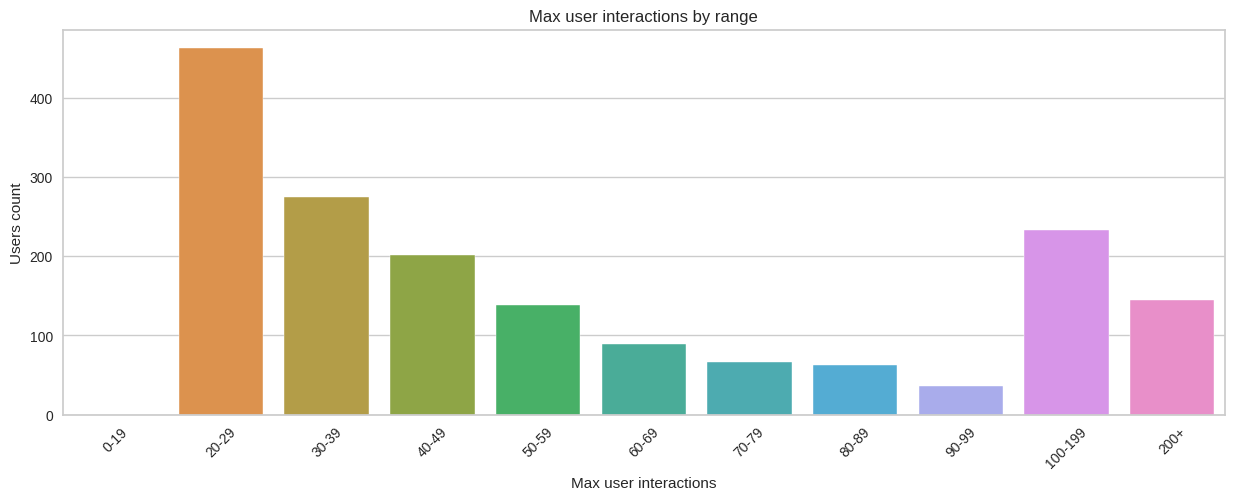

In [49]:
plot_max_user_interactions_bins(max_user_interactions_by_bin, figsize=(15, 5))

**Observations**

* We are not interested into users with more that 200 interactions. We consider them outlier users.
* Same story with users less than 20 interations. This users get wrong results with collaborative fiilterging models. They are not suitable to buils an interactions test set.

**Step 5**: Remove ranges with outliers users.

In [50]:
selected_bins = max_user_interactions_by_bin['n_interactions_bin'].values[1:-1].tolist()
selected_bins

['20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100-199']

**Step 5**: Select 15 users from each group to build a interactions test set that represent the average user behavior.

In [51]:
groups = user_interaction_bins[['n_interactions_bin', 'user_id']] \
    .drop_duplicates() \
    .groupby('n_interactions_bin')

In [52]:
import random 

users_sample_size = 15
test_set_users = []

for curr_bin in selected_bins:
    group_df = groups.get_group(curr_bin)
    user_ids = group_df['user_id'].values.tolist()
    test_set_users.extend(random.sample(user_ids, users_sample_size))
    
len(test_set_users)

135

**Step 6**: Split and save dev and test interactions sets.

In [53]:
split_criterion = interactions['user_id'].isin(test_set_users)

interactions_dev_set  = interactions[~split_criterion]
interactions_test_set = interactions[split_criterion]

In [54]:
interactions_dev_set.shape, interactions_test_set.shape

((185109, 4), (9164, 4))

In [55]:
len(interactions_dev_set)/len(interactions), len(interactions_test_set)/len(interactions)

(0.9528292660328507, 0.04717073396714932)

In [56]:
del interactions

In [57]:
ut.save_df(interactions_dev_set,  f'{DATASET_PATH}/interactions_dev_set.json' )
ut.save_df(interactions_test_set, f'{DATASET_PATH}/interactions_test_set.json')

In [59]:
interactions_test_set

,user_id,item_id,rating,timestamp
4,103371,1,4,2006-03-09 22:29:16
31,126226,1,4,2016-05-24 00:29:23
86,25439,1,3,2005-02-11 11:45:40
87,25677,1,3,2019-08-20 14:22:51
88,26245,1,4,2009-05-13 06:28:56
...,...,...,...,...
194264,21529,176237,3,2017-08-01 03:25:30
194265,21529,176239,4,2017-08-01 03:23:50
194267,21529,176257,3,2017-08-02 20:55:47
194268,21529,176259,3,2017-08-02 20:56:43


# Upload items and interactions to RecChatBotAPI

Finally is necessary insert items and interactions into **Recommendations Chatbot API** databases.

In [58]:
client = RecChatBotV1ApiClient()

**Step 1**: Add items to Charbot API databases

In [52]:
client.add_items(items)

2024-04-21 15:28:21,348 - INFO - Page Size: 1000
2024-04-21 15:28:26,723 - INFO - Page: 1/19, Size: 1000
2024-04-21 15:28:32,080 - INFO - Page: 2/19, Size: 1000
2024-04-21 15:28:37,613 - INFO - Page: 3/19, Size: 1000
2024-04-21 15:28:43,023 - INFO - Page: 4/19, Size: 1000
2024-04-21 15:28:48,391 - INFO - Page: 5/19, Size: 1000
2024-04-21 15:28:54,250 - INFO - Page: 6/19, Size: 1000
2024-04-21 15:28:59,612 - INFO - Page: 7/19, Size: 1000
2024-04-21 15:29:04,929 - INFO - Page: 8/19, Size: 1000
2024-04-21 15:29:10,375 - INFO - Page: 9/19, Size: 1000
2024-04-21 15:29:16,000 - INFO - Page: 10/19, Size: 1000
2024-04-21 15:29:21,786 - INFO - Page: 11/19, Size: 1000
2024-04-21 15:29:27,358 - INFO - Page: 12/19, Size: 1000
2024-04-21 15:29:32,872 - INFO - Page: 13/19, Size: 1000
2024-04-21 15:29:38,406 - INFO - Page: 14/19, Size: 1000
2024-04-21 15:29:44,124 - INFO - Page: 15/19, Size: 1000
2024-04-21 15:29:49,609 - INFO - Page: 16/19, Size: 1000
2024-04-21 15:29:55,182 - INFO - Page: 17/19, Si

[]

In [53]:
interactions_dev_set.shape

(185074, 4)

**Step 2**: Add interactions dev set to Charbot API databases (the test set will be used to evalua chatbot API).

In [54]:
client.add_interactions(interactions_dev_set)

2024-04-21 15:30:04,349 - INFO - Page Size: 5000
2024-04-21 15:30:04,585 - INFO - Page: 1/38, Size: 5000
2024-04-21 15:30:04,962 - INFO - Page: 2/38, Size: 5000
2024-04-21 15:30:05,178 - INFO - Page: 3/38, Size: 5000
2024-04-21 15:30:05,382 - INFO - Page: 4/38, Size: 5000
2024-04-21 15:30:05,580 - INFO - Page: 5/38, Size: 5000
2024-04-21 15:30:05,779 - INFO - Page: 6/38, Size: 5000
2024-04-21 15:30:05,982 - INFO - Page: 7/38, Size: 5000
2024-04-21 15:30:06,189 - INFO - Page: 8/38, Size: 5000
2024-04-21 15:30:06,382 - INFO - Page: 9/38, Size: 5000
2024-04-21 15:30:06,779 - INFO - Page: 10/38, Size: 5000
2024-04-21 15:30:06,985 - INFO - Page: 11/38, Size: 5000
2024-04-21 15:30:07,185 - INFO - Page: 12/38, Size: 5000
2024-04-21 15:30:07,393 - INFO - Page: 13/38, Size: 5000
2024-04-21 15:30:07,599 - INFO - Page: 14/38, Size: 5000
2024-04-21 15:30:07,801 - INFO - Page: 15/38, Size: 5000
2024-04-21 15:30:07,997 - INFO - Page: 16/38, Size: 5000
2024-04-21 15:30:08,327 - INFO - Page: 17/38, Si

[]

In [63]:
ctx = AppContext()

api_interactions = ints_to_df(await ctx.interaction_service.find_all())
api_interactions.shape

2024-08-31 16:31:38,390 - INFO - Load pretrained SentenceTransformer: all-mpnet-base-v2
2024-08-31 16:31:41,248 - INFO - Use pytorch device_name: cuda
2024-08-31 16:31:41,338 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
2024-08-31 16:31:41,357 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


(190390, 3)

## Fun users interactions

Create artificial users that simulate fans of specific genres to enhance collaborative filtering models and embedding similarity matching.

**Step 1**: Build prompts to search items by content similarity(via embeddings). 

In [64]:
searchs = [
    ('pixar animated movie for children', 200),
    ('science fiction, action', 100),
    ('war weapons', 70),
    ('iron man, x-men, spider man, bat man, flash, avengers, ant-man, hulk, guardians of the galaxy, marvel, green lantern, superman, watchmen, thor, deadpool, wonder woman, strange, justice League, captain america, logans, kick ass, John Wick', 150),
    ('sci-fi, action, future', 130),
    ('Mission Impossible, spies, bourne identity, 007', 70),
    ('comedy movies', 200),
    ('horror', 100),
    ('thiller, suspense', 150),
    ('love, romance', 150),
    ('time travel', 100),
    ('dead, zombies, post apocalyptic', 100),
    ('software', 100),
    ('hackers', 100)
]

**Step 2**: Create fun users interactions.

In [70]:
items = await search_items_by_content(
    interactions_dev_set, 
    content     = 'hackers',
    min_rating  = 3, 
    limit       = 8,
    min_release = 1990,
    order_popularity = False
)

show(items)

,index,id,title,release,genres,rating,poster
0,0,100745,TPB AFK: The Pirate Bay Away from Keyboard,2013,"[documentary, crime]",3.666667,
1,1,140860,Hacker,2002,"[thriller, action]",4.000000,
2,2,151783,Inside The Dark Web,2014,[documentary],4.000000,
3,3,166755,Hacker,2016,"[crime, drama, thriller]",5.000000,
4,4,170,Hackers,1995,"[action, adventure, crime, thriller]",3.338983,
5,5,45172,23,1998,"[drama, thriller]",3.800000,
6,6,97692,We Are Legion: The Story of the Hacktivists,2012,[documentary],3.500000,


In [71]:
fun_user_interactions = []
max_user_id = interactions_dev_set['user_id'].max()

for search in searchs:    
    items = await search_items_by_content(
        interactions_dev_set, 
        search[0],
        min_rating  = 3, 
        limit       = search[1],
        min_release = 1990,
        order_popularity = False
    )    
    
    items = items.rename(columns={'id': 'item_id'})
    items['rating'] = items['item_id'].apply(lambda x: 4 if random.random() > 0.5 else 5)
    items['user_id'] = max_user_id
    items = items[['item_id', 'user_id', 'rating']]
    
    max_user_id +=1
    
    fun_user_interactions.append(items)

fun_user_interactions = pd.concat(fun_user_interactions)
fun_user_interactions['timestamp'] = datetime.now()

In [72]:
fun_user_interactions

,item_id,user_id,rating,timestamp
0,1,162521,5,2024-08-31 16:37:55.041314
1,101262,162521,4,2024-08-31 16:37:55.041314
2,105468,162521,4,2024-08-31 16:37:55.041314
3,106022,162521,5,2024-08-31 16:37:55.041314
4,106423,162521,4,2024-08-31 16:37:55.041314
...,...,...,...,...
64,8129,162534,5,2024-08-31 16:37:55.041314
65,8581,162534,4,2024-08-31 16:37:55.041314
66,8628,162534,4,2024-08-31 16:37:55.041314
67,92475,162534,5,2024-08-31 16:37:55.041314


**Step 3**: Insert fun users interactions.

In [62]:
client.add_interactions(fun_user_interactions)

2024-04-21 15:30:56,299 - INFO - Page Size: 5000
2024-04-21 15:30:56,386 - INFO - Page: 1/1, Size: 1158


[]

In [63]:
ctx = AppContext()

api_interactions = ints_to_df(await ctx.interaction_service.find_all())
api_interactions.shape

2024-04-21 15:30:59,393 - INFO - Load pretrained SentenceTransformer: all-mpnet-base-v2
2024-04-21 15:31:01,832 - INFO - Use pytorch device_name: cuda
2024-04-21 15:31:01,892 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
2024-04-21 15:31:01,894 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


(186232, 3)